In [1]:
import sys
import pickle 

sys.path.append(sys.path[0] + "/..")  # Adds higher directory to python modules path.

import numpy as np
from Functions import renormalize, scomplex, plotting
import matplotlib.pyplot as plt
import networkx as nx
import powerlaw as pwl
import seaborn as sns
import scipy
from matplotlib.colors import LinearSegmentedColormap
import xgi

plt.rcParams["text.usetex"] = True

import matplotlib.colors as mcolors

from matplotlib.colors import LinearSegmentedColormap

colors = ["#003F5C","#2F4B7C","#665191","#A05195","#D45087","#F95D6A","#FF7C43","#FFA600"]
colors_sequential = colors + colors + colors + colors 
colors = ["#02405c", "#fea600", "#a20655", "#5e96c5", "#4b3596", "#fa6ca9", "#8d6cf6"]
colors_curves = colors+ colors+ colors+ colors


## Generate Simplicial Complex

### Pseudofractal & Apollonian

In [ ]:
steps = 5
sc = scomplex.pseudofractal_d2(steps)
#sc = scomplex.pseudofractal_d3(steps)
#sc = scomplex.apollonian_d2(steps)

### Real network

In [4]:
#["asoiaf", "ego-facebook","subelj_euroroad_euroroad", "dimacs10-netscience", "arenas-email", "dimacs10-celegans_metabolic", "moreno_propro_propro"]
#["mammalia-voles-bhp-trapping.edges","reptilia-tortoise-network-fi.edges"]

f = open("../Datasets/out.ego-facebook","r")
maxd = 2
sc = scomplex.import_network_data(f, maxd)

### Real Networkx XGI

In [3]:

# email-enron,email-eu,"hospital-lyon”,"contact-high-school”,“contact-primary-school”,“tags-ask-ubuntu”,“congress-bills”,“disgenenet”,“diseasome”,
#“ndc-substances”,“coauth-mag-geology”,“coauth-mag-history”,

# email-enron, hospital-lyon, contact-high-school, diseasome, “disgenenet”

name = "email-enron"
maxd = 3
sc = scomplex.import_network_data_xgi(name,maxd)

### NGF

In [3]:
# Network Geometry with Flavor
d = 2 # Dimension 
N = 300 # Number of nodes
s = 1 # Flavour
m = 1 # Number of simplices added at each iteration
beta = 100 # Inverse temperature

sc = scomplex.NGF(d,N,s,beta,m) 

### Lattice

In [77]:
G = nx.grid_graph([10,10],periodic=False)
for s in range(1):
    G = scomplex.subdivide(G)
sc = scomplex.convert_graph_to_sc(G)
sc["n0"]

280

## Plot complex

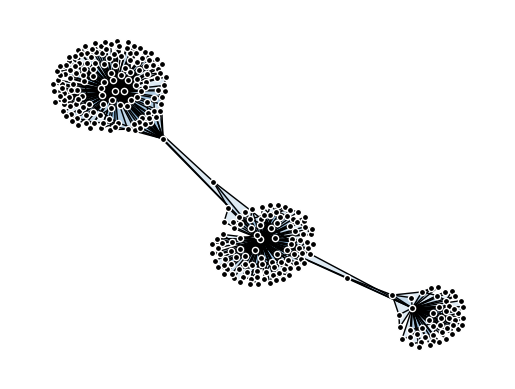

In [16]:
# Plot simplicial complex (might be slow)

f,ax = plt.subplots(1,1)
plotting.plot_complex(sc,ax = ax,face_color=[colors[3]],layout = "spring", iterations = 100, node_size=20)
ax.collections[0].set_linewidth(1) 
ax.collections[0].set_edgecolor("#FFFFFF") 

## Statistical physics of information diffusion

Compute entropic susceptibility/specific heat curves for the chosen Laplacians


In [13]:

sparse = False
num_eigs = 500

# Define strings which specify the Laplacians to consider

laplacians_types = ["12"]
#laplacians_types = ["01","10"]
#laplacians_types = ["01","02","10","12","20","21"]
#laplacians_types = ["01","10"]
#laplacians_types = ["01","02","12"]
#laplacians_types = ["01","03","13","23"]
#laplacians_types = ["01","02","03","10","12","13","20","21","23","30","31","32"]

# Compute eigenvalues of the Laplacians and their specific heat curves

taumin = -3 # Heat curve starts from 10**taumin
taumax = 5 # Heat curve ends at 10**taumax
ntau = 200 # Number of taus to consider in the interval

sp_heats = []
sp_dims = []

for l in laplacians_types:  
    print(f"L_({l[0]},{l[1]})")  
    L = scomplex.diffusion_laplacian(sc, k=int(l[0]), l=int(l[1]),sparse = sparse)
  
    if sparse:
        D,U = scipy.sparse.linalg.eigsh(L.asfptype(),k = num_eigs, which = "SM")
        D = np.append(D,1000000*np.ones(L.shape[0]-num_eigs),axis=0)
    else:
        D,U = np.linalg.eigh(L)
        D = np.abs(D)

    specific_heat,tau_space, __ = renormalize.compute_heat(D,taumin,taumax,ntau)
    spectral_dimension,tau_space = renormalize.compute_spectral_d(D,taumin,taumax,ntau)
    sp_heats.append(specific_heat)
    sp_dims.append(spectral_dimension)


L_(1,2)


/Users/marconurisso/Desktop/Lavoro/Simplicial_Renormalization/HodgeLaplacianRenorm/higher_order_LRG/HOLR/Experiments_setups/../Functions/renormalize.py:28: RuntimeWarning: overflow encountered in exp
  mu[i] = 1 / np.sum(np.exp(-tau * (D - D[i])))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


### Save Entropic Susceptibilities Data

In [25]:
name = "email-univ"
with open(f'../Experiments_results/Diffusion_Laplacians/Heat_curves/RealData/sp_heats/{name}_sp_heats.pickle', 'wb') as handle:
    pickle.dump(sp_heats, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Load Entropic Susceptibilities Data Real Networks

In [16]:
# Load real data

# pickle: asoiaf, ego-facebook,subelj_euroroad_euroroad, dimacs10-netscience, arenas-email, celegans, ecoli, mmusculus, drosophila
# email-enron, hospital-lyon, contact-high-school, diseasome, disgenenet

name = "disgenenet"

with open(f'../Experiments_results/Diffusion_Laplacians/Heat_curves/RealData/sp_heats/{name}_sp_heats.pickle', 'rb') as handle:
    sp_heats = pickle.load(handle)

d = int((-1+np.sqrt(1+4*len(sp_heats)))/2)
laplacians_types = [f"{k}{m}" for k in range(d+1) for m in range(d+1) if m!=k]
tau_space = np.logspace(-5,5,200)[:200-1]



### Load Entropic Susceptibilities Data NGF

In [3]:
# Load NGF data (deserialize)

d = 4
s = 1
nrep = 10#10
N = 3000


with open(f'../Experiments_results/Diffusion_Laplacians/Heat_curves/NGF/Data/d{d}s{s}b5_{nrep}rep_{N}nodes.pickle', 'rb') as handle:
    sp_heats = pickle.load(handle)


if d == 1:
        laplacians_types = ["01"]
else:
    laplacians_types = ["01"]+[f"{l}{d}" for l in range(d)]

taumin = -3
taumax = 5
ntau = 200
tau_space = np.logspace(taumin,taumax,ntau)[:ntau-1]
if d == 1:
    laplacians_types = ["01"]
else:
    laplacians_types = ["01"]+[f"{k}{d}" for k in range(0,d)]

### Load Entropic Susceptibilities Data Pseudofractal

In [60]:
d = 3

with open(f'../Experiments_results/Diffusion_Laplacians/Heat_curves/Pseudofractal/sp_heats/PF32_sp_heats.pickle', 'rb') as handle:
    sp_heats = pickle.load(handle)

if d == 1:
        laplacians_types = ["01","10"]
else:
    laplacians_types = ["01"]+[f"{l}{d}" for l in range(d)]

taumin = -3
taumax = 5
ntau = 200
tau_space = np.logspace(taumin,taumax,ntau)[:ntau-1]

laplacians_types = [f"{a}{b}" for a in range(d+1) for b in range(d+1) if a != b ]


## Plot Curves

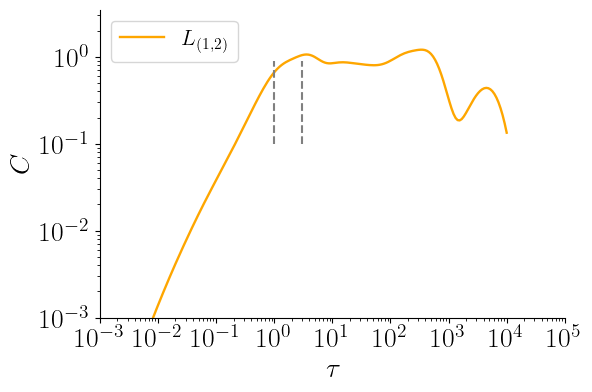

In [15]:
which_plot = range(len(laplacians_types))
cols  =colors_curves

names = [f"$L_{{({int(l[0])},{int(l[1])})}}$" for l in laplacians_types]
f,ax = plt.subplots(1,1,figsize = (6,4))
for id,i in enumerate(which_plot):
    ax.loglog(tau_space,sp_heats[i],color = cols[id+1],linewidth = 1.7,alpha = 1)
    #ax.semilogx(tau_space,sp_dims[i],linestyle = '--', color = colors_curves[i+1],linewidth = 1.7,alpha = 1)


ax.set_ylim([10**-3,3.5])
ax.set_xlim([10**-3,10**5])

ax.legend([names[which_plot[i]] for i in range(len(which_plot))],fontsize = 16)


ax.set_xlabel(r"$\tau$",fontsize = 20)
ax.set_ylabel(r"$C$",fontsize = 20)

plt.xticks(fontsize = 20)

plt.yticks(fontsize = 20)

#ax.vlines(x = 1,ymin = 10**-1,ymax = 0.9,linestyles="--",color = [0.5,0.5,0.5])

sns.despine()


#plt.savefig(f'../Experiments_results/Diffusion_Laplacians/Heat_curves/Pseudofractal/PF3_curves.pdf')


### Plot all curves 

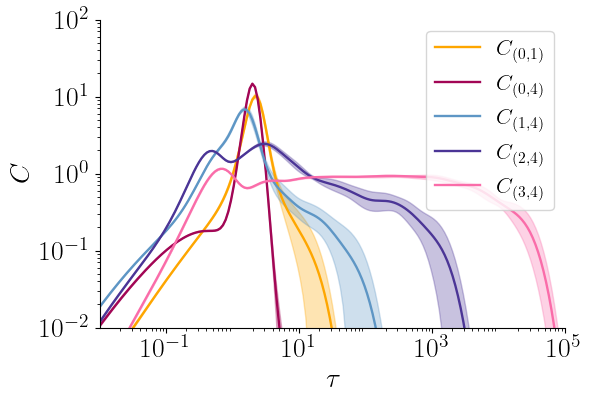

In [5]:
names = [f"$L_{{({int(l[0])},{int(l[1])})}}$" for l in laplacians_types]
f,ax = plt.subplots(1,1,figsize = (6,4))




for i in range(len(laplacians_types)):
    #for n in range(10):
    #    plt.loglog(tau_space,sp_heats[i][n],color = colors_curves[i+1],linewidth = 1,alpha = 0.2,label = "")
    sp_heats_std = np.std(sp_heats[i],0)
    sp_heats_mean = np.mean(sp_heats[i],0)
    ax.fill_between(tau_space, sp_heats_mean + 1.96*sp_heats_std/np.sqrt(nrep),sp_heats_mean - 1.96*sp_heats_std/np.sqrt(nrep), alpha=0.3, color = colors_curves[i+1])
    ax.semilogx(tau_space,sp_heats_mean, color = colors_curves[i+1],linewidth = 1.7, label = f"$C_{{({laplacians_types[i][0]},{laplacians_types[i][1]})}}$")


# for i in range(len(laplacians_types)):
#     means = np.mean(np.array(sp_heats[i]),0)
#     stds = np.sqrt((nrep-1)/(nrep))*np.std(np.array(sp_heats[i]),0)
#     ax.fill_between(tau_space, means - stds,means + stds, color = colors_curves[i+1],alpha = 0.3,label = "")
#     ax.loglog(tau_space,means,color = colors_curves[i+1],linewidth = 1.7,alpha = 1,label = names[i])

ax.set_xscale("log")
ax.set_yscale("log")

ax.set_ylim([10**-2,100])

ax.set_xlim([10**-2,10**5])
ax.legend(fontsize = 16)
ax.set_xlabel(r"$\tau$",fontsize = 20)
ax.set_ylabel(r"$C$",fontsize = 20)
plt.xticks([10**-1,10**1,10**3,10**5],fontsize = 20)
plt.yticks(fontsize = 20)


#ax.hlines(y =1.2,xmin=0.6,xmax = 20, linestyles='--',color = [0.5,0.5,0.5])
#ax.hlines(y =1,xmin=100,xmax = 1*10**4,linestyles='--',color = [0.5,0.5,0.5])
#ax.vlines(x =0.8,ymin=0.1,ymax =2,linestyles='--',color = [0.5,0.5,0.5])

sns.despine()
#plt.savefig(f'../Experiments_results/Diffusion_Laplacians/Heat_curves/RealData/{name}_curves.pdf')
plt.savefig(f'../Experiments_results/Diffusion_Laplacians/Heat_curves/NGF/d{d}s{s}b5_{N}nodes_{nrep}rep.pdf',bbox_inches="tight")


## Plot adjacency graph

In [35]:
k = 0
l = 1
A = scomplex.adjacency_of_order(sc,k,l,False)
G = nx.from_numpy_matrix(A)
weights = [0.4*G[u][v]['weight'] for u,v in G.edges]

layouts = nx.kamada_kawai_layout(G)

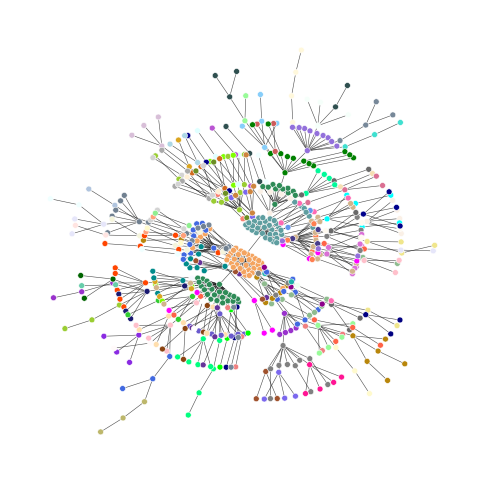

In [41]:
f,ax = plt.subplots(1,1,figsize = (6,6))
nx.draw(G,pos = layouts,node_size = 18,width = 0.4, ax = ax, node_color = colors,edge_color = [0.1,0.1,0.1])

ax.collections[1].set_alpha(0.8)
ax.collections[0].set_linewidth(0.4) 
ax.collections[0].set_edgecolor("#FFFFFF") 

#plt.savefig(f"../Experiments_results/Diffusion_Laplacians/Graphs/clusters_d3_tau0p6.pdf")



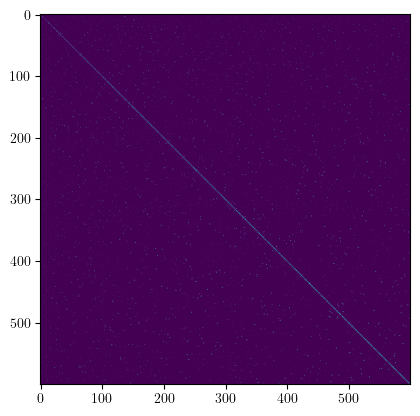

In [40]:
k = 0
l = 1
scc = sc
tau = 2
L = scomplex.diffusion_laplacian(scc,k,l,False)
rho = scipy.linalg.expm(-tau*L)

Gv = nx.Graph()

Gv.add_nodes_from([i for i in range(scc[f"n{k}"])])
for i in range(scc[f"n{k}"]):
    for j in range(i+1,scc[f"n{k}"]):
        if rho[i,j] >= min(rho[i,i],rho[j,j]):
            Gv.add_edge(i,j)

idx_components = {u:i for i,node_set in enumerate(nx.connected_components(Gv)) for u in node_set}
clusters = [idx_components[u] for u in Gv.nodes]
clist = list(mcolors.CSS4_COLORS)*10
np.random.shuffle(clist)
colors = clusters.copy()
for i in range(len(clusters)):
    colors[i] = clist[clusters[i]]
plt.imshow(rho)
#plt.savefig(f'../Experiments_results/rho_matrix.pdf')

In [63]:
layout = nx.spring_layout(nx.from_edgelist(sc["edges"]))

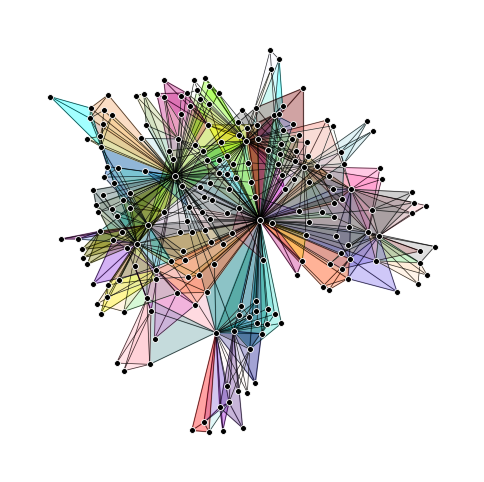

In [141]:
f,ax = plt.subplots(1,1,figsize = (6,6))
plotting.plot_complex(sc,ax = ax,face_color=colors,pos=layout,edge_width=0.5,node_size=18)

ax.collections[1].set_alpha(0.8)
ax.collections[0].set_linewidth(0.6) 
ax.collections[0].set_edgecolor("#FFFFFF") 

plt.savefig(f"../Experiments_results/Diffusion_Laplacians/Graphs/clusters_d3_tau0p6_C.pdf")


## Renormalize

### Multiple steps of renormalization

In [25]:
lmax = 4 # Number of steps
diff_order = 0 # Diffusion order
int_order = 1 # Interaction order
tau = 0.3 # Diffusion time
VERBOSE = True # Whether to print the number of nodes after each step

sequence = renormalize.renormalize_steps(sc,lmax = lmax,tau = tau, diff_order = diff_order, int_order = int_order, VERBOSE = VERBOSE)


200
39
21
21


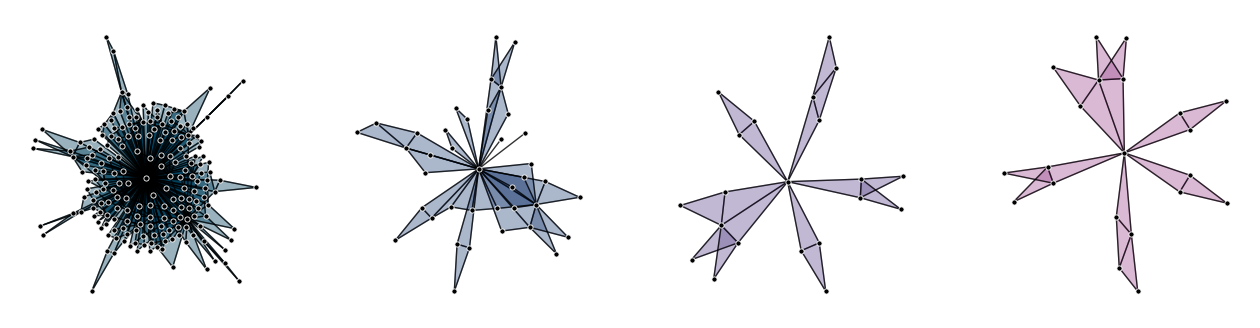

In [26]:
# Plot sequence

f,axs = plt.subplots(1,lmax,figsize = (4*lmax,4))
i = 0
for new_sc in sequence:
    col = colors_sequential[i]
    plotting.plot_complex(new_sc,ax = axs[i],face_color=[col],face_alpha=0.4,node_size=14,iterations=3000)
    axs[i].collections[1].set_alpha(0.8)
    axs[i].collections[0].set_linewidth(0.6) 
    axs[i].collections[0].set_edgecolor("#FFFFFF") 
    i+=1
#plt.savefig(f"../Experiments_results/Diffusion_Laplacians/Renormalizations/NGF/flow_L01.pdf")

### Single step of renormalization

In [ ]:
diff_order = 0
int_order = 1
new_sc, mapnodes, clusters = renormalize.renormalize_single_step(sc, tau = 1.3, diff_order = diff_order, int_order = int_order, D = None, U = None)

### Renormalize & Plot change tau

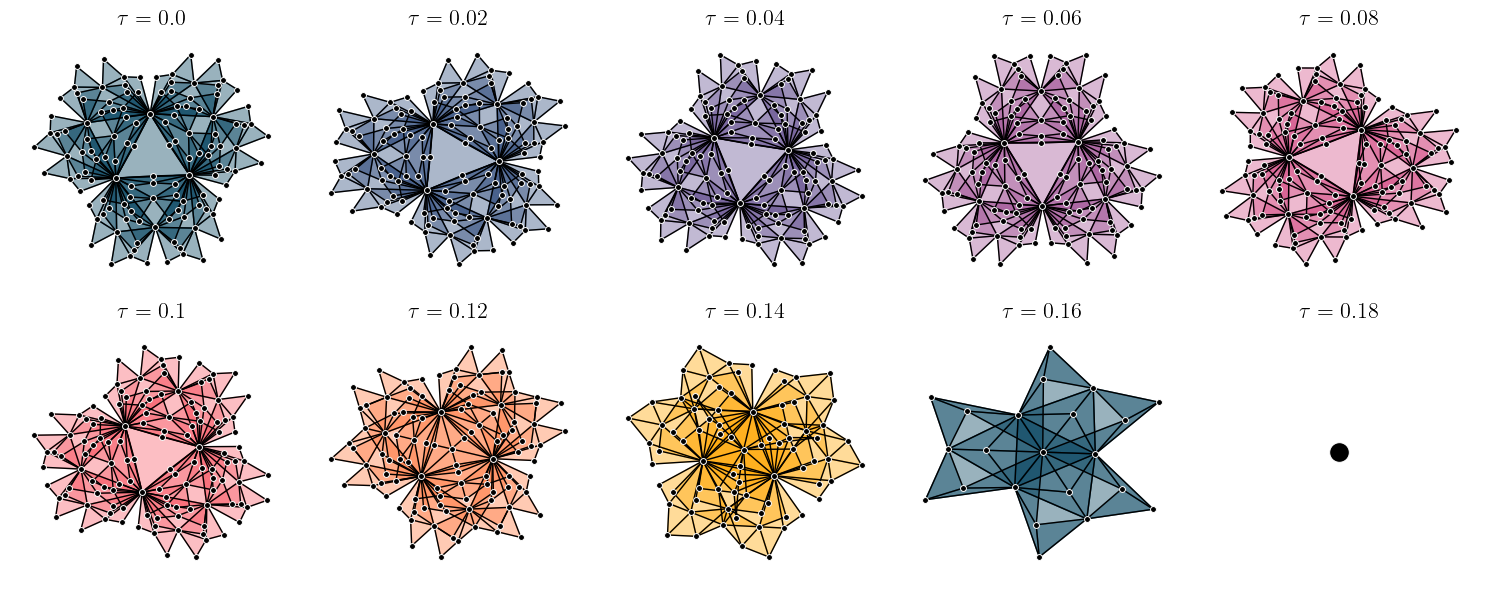

In [6]:
nplots = 10
diff_order = 2
int_order = 0
tau_min = 0
tau_max = 0.18

f,axs = plt.subplots(2,nplots//2,figsize = (nplots//2*3,2*3))
tau_space = np.linspace(tau_min,tau_max,nplots)

L = scomplex.diffusion_laplacian(sc,diff_order,int_order)
D, U = scipy.linalg.eigh(L)

for t,tau in enumerate(tau_space):
    ax = axs[t//(nplots//2),np.mod(t,nplots//2)]
    new_sc,__,__ = renormalize.renormalize_single_step(sc,tau,diff_order,int_order,D,U,VERBOSE=False)
    col = colors_sequential[t]
    plotting.plot_complex(new_sc,ax = ax,face_color=[col],face_alpha=0.4,node_size=18,iterations=4000)
   

    ax.set_title(r"$\tau = "+f"{np.round(tau,2)}$",fontsize = 16)
    #ax[i].collections[1].set_alpha(0.8)
    ax.collections[0].set_linewidth(0.7) 
    ax.collections[0].set_edgecolor("#FFFFFF") 

plt.tight_layout()
#plt.savefig(f"../Experiments_results/Diffusion_Laplacians/Renormalizations/Pseudofractal/L{diff_order}{int_order}_change_tau.pdf")


### Check that the plateau is preserved

In [ ]:
taumin = -2
taumax = 6
ntau = 250

diff_order = 1
int_order = 2

L = scomplex.diffusion_laplacian(sc,diff_order,int_order)
D, U = np.linalg.eigh(L)

specific_heat,tau_space, __ = renormalize.compute_heat(D,taumin,taumax,ntau)

In [5]:
# Reference (0,1) Laplacian
L = scomplex.diffusion_laplacian(sc,0,1)

D0,U0 = np.linalg.eigh(L)
specific_heat0,tau_space, __ = renormalize.compute_heat(D0,taumin,taumax,ntau)

In [ ]:
N = 50
tau_space_spars = tau_space[0:-1:len(tau_space)//N]
nodes = np.zeros(len(tau_space_spars))
nodes2 = np.zeros(len(tau_space_spars))

for i,t in enumerate(tau_space_spars):
    print(i)
    new_sc, mapnodes, clusters = renormalize.renormalize_single_step(sc, tau = t, diff_order = 1, int_order = 2, D = D, U = U,VERBOSE = False)
    new_sc2, mapnodes, clusters = renormalize.renormalize_single_step(sc, tau = t, diff_order = 0, int_order = 1, D = D0, U = U0,VERBOSE = False)
    nodes[i] = new_sc["n0"]
    nodes2[i] = new_sc2["n0"]

In [2]:
name = "NGF"
with open(f'../Experiments_results/Diffusion_Laplacians/Renormalizations/Change_tau/data_{name}.pickle', 'rb') as handle:
    All_data = pickle.load(handle)

tau_space = All_data["tau_space"]
tau_space_spars = All_data["tau_space_spars"]
specific_heat = All_data["spheat12"]
specific_heat0 = All_data["spheat01"]
nodes01 = All_data["nodes01"]
nodes12 = All_data["nodes12"]
sc = All_data["sc"]

In [7]:
L = scomplex.diffusion_laplacian(sc,1,2)
D,U = np.linalg.eigh(L)
Z = np.zeros(len(tau_space))
for i,t in enumerate(tau_space):
    Z[i] = np.sum(np.exp(-t*D))
Z = Z/sc["n1"]

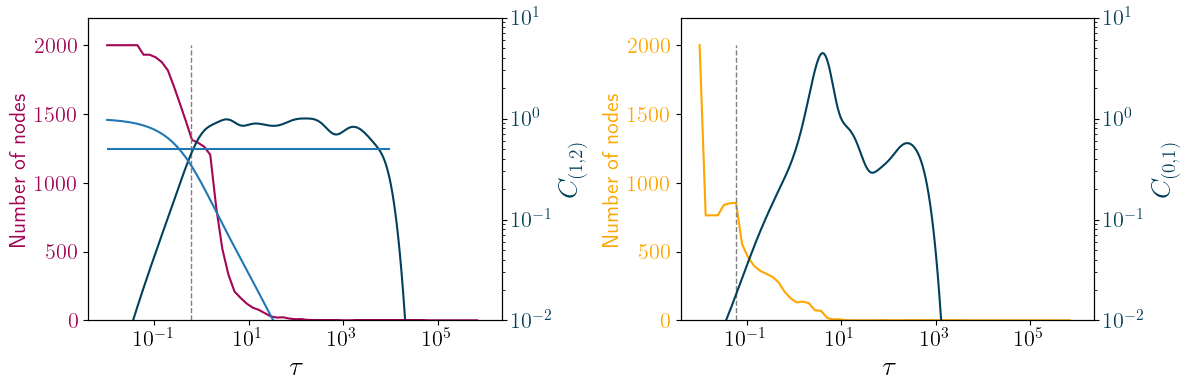

In [9]:
fig, axs = plt.subplots(1,2,figsize = (12,4))

ax1 = axs[0]
ax1.set_xlabel(r'$\tau$',fontsize = 20)
ax1.set_ylabel('Number of nodes', color=colors_curves[2],fontsize = 16)
ax1.semilogx(tau_space_spars, nodes12, color=colors_curves[2])
ax1.tick_params(axis='y', labelcolor=colors_curves[2])
ax1.set_ylim([0,sc["n0"]+200])

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = colors_curves[0]
ax2.set_ylabel('$C_{{(1,2)}}$', color=color, fontsize = 20)  # we already handled the x-label with ax1
ax2.loglog(tau_space, specific_heat, color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim([10**-2,10])

ax2.semilogx(tau_space,Z)
ax2.hlines(0.5,10**-2,10**4)

ax3 = axs[1]
ax3.set_xlabel(r'$\tau$',fontsize = 20)
ax3.set_ylabel(r"Number of nodes", color=colors_curves[1],fontsize = 16)
ax3.semilogx(tau_space_spars, nodes01, color=colors_curves[1])
ax3.tick_params(axis='y', labelcolor=colors_curves[1])
ax3.set_ylim([0,sc["n0"]+200])

ax4 = ax3.twinx()  # instantiate a second axes that shares the same x-axis

color = colors_curves[0]
ax4.set_ylabel('$C_{{(0,1)}}$', color=color, fontsize = 20)  # we already handled the x-label with ax1
ax4.loglog(tau_space, specific_heat0, color=color)
ax4.tick_params(axis='y', labelcolor=color)
ax4.set_ylim([10**-2,10])



ax1.tick_params(axis='both', which='major', labelsize=16)
ax2.tick_params(axis='both', which='major', labelsize=16)
ax3.tick_params(axis='both', which='major', labelsize=16)
ax4.tick_params(axis='both', which='major', labelsize=16)

ax1.vlines(x = 0.6,ymin = 0, ymax = 2000,color = "gray",linestyle = "--",linewidth = 1)
ax3.vlines(x = 0.06,ymin = 0, ymax = 2000,color = "gray",linestyle = "--",linewidth = 1)

plt.tight_layout()  # otherwise the right y-label is slightly clipped
#plt.savefig(f'../Experiments_results/Diffusion_Laplacians/Renormalizations/Change_tau/{name}.pdf')

In [145]:
All_data = {"sc":sc,"tau_space":tau_space,"tau_space_spars":tau_space_spars,"nodes12":nodes12,"nodes01":nodes01,"spheat12":specific_heat,"spheat01":specific_heat0}
with open(f'../Experiments_results/Diffusion_Laplacians/Renormalizations/Change_tau/data_PF_steps6_renorm12_and_01.pickle', 'wb') as handle:
    pickle.dump(All_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [6]:
taustar = 0.6

diff_order_ren = 1
int_order_ren = 2

new_sc, mapnodes, clusters = renormalize.renormalize_single_step(sc, tau = taustar, diff_order = diff_order_ren, int_order = int_order_ren, D = D, U = U)


1318


In [7]:
tauref = 0.06
new_sc_ref, mapnodes, clusters = renormalize.renormalize_single_step(sc, tau = tauref, diff_order =0, int_order = 1, D = D0, U = U0)


854


In [8]:

Lnew_ref = scomplex.diffusion_laplacian(new_sc_ref, diff_order,int_order)
Dnew_ref, __ = np.linalg.eigh(Lnew_ref)

new_specific_heat_ref,tau_space, __ = renormalize.compute_heat(Dnew_ref,taumin,taumax,ntau)

In [9]:
Lnew = scomplex.diffusion_laplacian(new_sc, diff_order,int_order)
Dnew, __ = np.linalg.eigh(Lnew)

new_specific_heat,tau_space, __ = renormalize.compute_heat(Dnew,taumin,taumax,ntau)

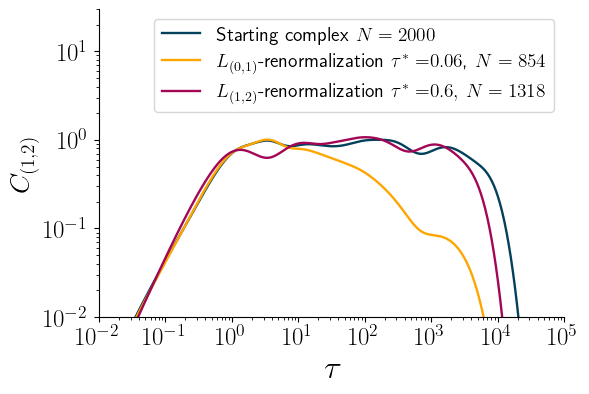

In [188]:
f,ax = plt.subplots(1,1,figsize = (6,4))

ax.loglog(tau_space,specific_heat,color = colors_curves[0],linewidth = 1.7)
ax.loglog(tau_space,new_specific_heat_ref,color = colors_curves[1],linewidth = 1.7)
ax.loglog(tau_space,new_specific_heat,color = colors_curves[2],linewidth = 1.7)

Ni = sc["n0"]
Nref = new_sc_ref["n0"]
Nnew = new_sc["n0"]

ax.set_ylim([10**-2,30])
ax.set_xlim([10**taumin,10**5])
ax.legend(["Starting complex" + f" $N = {Ni}$ ","$L_{(0,1)}$-renormalization"+r" $\tau^* = $"+f"${np.round(tauref,2)}$," + f" $N = {Nref}$ ",f"$L_{{({diff_order_ren},{int_order_ren})}}$-renormalization"+r" $\tau^* = $"+f"${np.round(taustar,2)},$" + f" $N = {Nnew}$ "],fontsize = 14)
#ax.legend(["Starting complex" + f" $N = {Ni}$ ",f"$L_{{({diff_order_ren},{int_order_ren})}}$-renormalization"+r" $\tau^* = $"+f"${np.round(taustar,2)},$" + f" $N = {Nnew}$ "],fontsize = 14)
ax.set_xlabel(r"$\tau$",fontsize = 24)
ax.set_ylabel(f"$C_{{({diff_order},{int_order})}}$",fontsize = 20)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
#ax.hlines(y = 1,xmin=5,xmax = 800,linestyles='--',color = [0.5,0.5,0.5])

#plt.vlines(taustar,10**-2,10**1)

sns.despine()

plt.savefig(f"../Experiments_results/Diffusion_Laplacians/Renormalizations/NGF/renormalize_NGF_{diff_order}{int_order}.pdf",bbox_inches="tight")



### Degrees

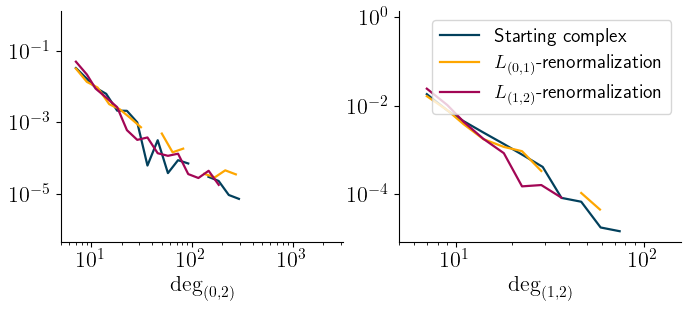

In [10]:
d = 2
f,axs = plt.subplots(1,d,figsize = (4*(d),3))
for i in range(d):
    A = scomplex.adjacency_of_order(sc,i,d)
    deg = np.sum(A,0)#/(scipy.special.comb(d+1,i+1)-1)
    pwl.plot_pdf(deg[deg>0],ax = axs[i],linewidth = 1.6,color = colors_curves[0])

for i in range(d):
    A = scomplex.adjacency_of_order(new_sc_ref,i,d)
    deg = np.sum(A,0)#/(scipy.special.comb(d+1,i+1)-1)
    pwl.plot_pdf(deg[deg>0],ax = axs[i],linewidth = 1.6,color = colors_curves[1])


for i in range(d):
    A = scomplex.adjacency_of_order(new_sc,i,d)
    deg = np.sum(A,0)#/(scipy.special.comb(d+1,i+1)-1)
    pwl.plot_pdf(deg[deg>0],ax = axs[i],linewidth = 1.6,color = colors_curves[2])


for i in range(d):
    axs[i].set_xlabel(r"$\mathrm{deg}_"+f"{{({i},{d})}}$",fontsize = 16)
    axs[i].xaxis.set_tick_params(labelsize=16)
    axs[i].yaxis.set_tick_params(labelsize=16)
    if i == 0:
        axs[i].set_xlim([5,10**3.5])
    else:
        axs[i].set_xlim([5,10**2.2])

plt.legend(["Starting complex","$L_{(0,1)}$-renormalization",f"$L_{{({diff_order_ren},{int_order_ren})}}$-renormalization"],fontsize = 14)

sns.despine()
plt.savefig(f"../Experiments_results/Diffusion_Laplacians/Renormalizations/NGF/renormalize_degrees_d2s1_L{diff_order}{int_order}_nodes1300_tau0p1.pdf",bbox_inches="tight")


### Renormalize and look at SIP

In [20]:
name = "arenas-email"

f = open(f"../Datasets/out.{name}","r")

i = 0
edges = []
for line in f:
    if i != 0:
        words = line.split()
        edges.append((words[0],words[1]))
    else:
        i += 1
f.close()
G = nx.from_edgelist(edges)
G = nx.convert_node_labels_to_integers(G)
G.remove_edges_from(nx.selfloop_edges(G))
Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
G = G.subgraph(Gcc[0])
sc = scomplex.convert_graph_to_sc(G,dim = 2)


with open(f'../Experiments_results/Diffusion_Laplacians/Heat_curves/RealData/sp_heats/{name}_sp_heats.pickle', 'rb') as handle:
    sp_heats = pickle.load(handle)

d = int((-1+np.sqrt(1+4*len(sp_heats)))/2)
laplacians_types = [f"{k}{m}" for k in range(d+1) for m in range(d+1) if m!=k]
tau_space = np.logspace(-5,5,200)[:200-1]

In [76]:
diff_order = 0
int_order = 2
new_sc, mapnodes, clusters = renormalize.renormalize_single_step(sc, tau =0.07, diff_order = diff_order, int_order = int_order, D = None, U = None)

650


In [54]:
sparse = False
num_eigs = 500

# Define strings which specify the Laplacians to consider

laplacians_types = [f"{i}{j}" for i in range(d+1) for j in range(d+1) if i != j]

taumin = -5
taumax = 5
ntau = 200 # Number of taus to consider in the interval

sp_heats = []

for l in laplacians_types:  
    print(f"L_({l[0]},{l[1]})")  
    L = scomplex.diffusion_laplacian(sc, k=int(l[0]), l=int(l[1]),sparse = sparse)

    if sparse:
        D,U = scipy.sparse.linalg.eigsh(L.asfptype(),k = num_eigs, which = "SM")
        D = np.append(D,1000000*np.ones(L.shape[0]-num_eigs),axis=0)
    else:
        D,U = np.linalg.eigh(L)
        D = np.abs(D)

    specific_heat,tau_space, __ = renormalize.compute_heat(D,taumin,taumax,ntau)
    sp_heats.append(specific_heat)


L_(0,1)
L_(0,2)
L_(1,0)
L_(1,2)
L_(2,0)
L_(2,1)


In [77]:
sparse = False
num_eigs = 500

# Define strings which specify the Laplacians to consider

laplacians_types = [f"{i}{j}" for i in range(d+1) for j in range(d+1) if i != j]

taumin = -5
taumax = 5
ntau = 200 # Number of taus to consider in the interval

sp_heats_r = []

for l in laplacians_types:  
    print(f"L_({l[0]},{l[1]})")  
    L = scomplex.diffusion_laplacian(new_sc, k=int(l[0]), l=int(l[1]),sparse = sparse)

    if sparse:
        D,U = scipy.sparse.linalg.eigsh(L.asfptype(),k = num_eigs, which = "SM")
        D = np.append(D,1000000*np.ones(L.shape[0]-num_eigs),axis=0)
    else:
        D,U = np.linalg.eigh(L)
        D = np.abs(D)

    specific_heat_r,tau_space, __ = renormalize.compute_heat(D,taumin,taumax,ntau)
    sp_heats_r.append(specific_heat_r)


L_(0,1)


/Users/marconurisso/Desktop/Lavoro/Simplicial_Renormalization/HodgeLaplacianRenorm/higher_order_LRG/HOLR/Experiments_setups/../Functions/renormalize.py:28: RuntimeWarning: overflow encountered in exp
  mu[i] = 1 / np.sum(np.exp(-tau * (D - D[i])))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


L_(0,2)
L_(1,0)
L_(1,2)
L_(2,0)
L_(2,1)


In [78]:
sp_heats_r02 = sp_heats_r

/Users/marconurisso/Desktop/Lavoro/Simplicial_Renormalization/HodgeLaplacianRenorm/higher_order_LRG/HOLR/Experiments_setups/../Functions/renormalize.py:71: RuntimeWarning: divide by zero encountered in log
  sp_heat =  np.log(sp_heat)
/Users/marconurisso/Desktop/Lavoro/Simplicial_Renormalization/HodgeLaplacianRenorm/higher_order_LRG/HOLR/Experiments_setups/../Functions/renormalize.py:71: RuntimeWarning: invalid value encountered in log
  sp_heat =  np.log(sp_heat)


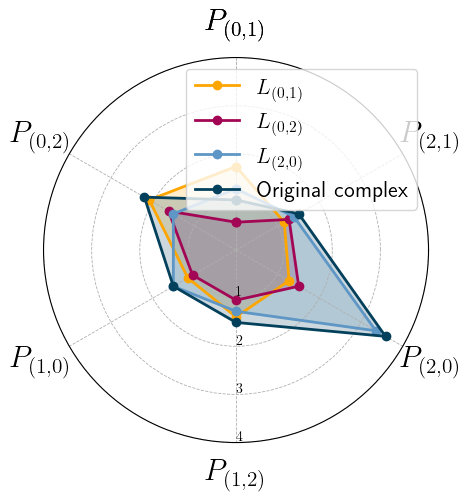

In [79]:
measure = np.zeros(len(laplacians_types))
measure_r20 = np.zeros(len(laplacians_types))
measure_r01 = np.zeros(len(laplacians_types))
measure_r02 = np.zeros(len(laplacians_types))

for i in range(len(laplacians_types)):
    measure[i] = renormalize.measure_SI(tau_space,sp_heats[i],epsilon=0.1,ymin = -4,ymax = 2,ny = 100)
    measure_r01[i] = renormalize.measure_SI(tau_space,sp_heats_r01[i],epsilon=0.1,ymin = -4,ymax = 2,ny = 100)
    measure_r20[i] = renormalize.measure_SI(tau_space,sp_heats_r20[i],epsilon=0.1,ymin = -4,ymax = 2,ny = 100)
    measure_r02[i] = renormalize.measure_SI(tau_space,sp_heats_r02[i],epsilon=0.1,ymin = -4,ymax = 2,ny = 100)
    
plt.figure(figsize=(5,5))
ax = plt.subplot(1,1,0+1, polar=True)
stats = measure
stats_r01 = measure_r01
stats_r20 = measure_r20
stats_r02 = measure_r02

angles = np.mod(np.pi/2 + np.linspace(0, 2*np.pi, len(laplacians_types), endpoint=False),2*np.pi)
stats = np.concatenate((stats,[stats[0]]))
stats_r20 = np.concatenate((stats_r20,[stats_r20[0]]))
stats_r01 = np.concatenate((stats_r01,[stats_r01[0]]))
stats_r02 = np.concatenate((stats_r02,[stats_r02[0]]))

angles = np.concatenate((angles,[angles[0]]))

ax.plot(angles, stats_r01, 'o-', linewidth=2,color = colors_curves[1],label = "$L_{(0,1)}$")
ax.fill(angles, stats_r01, alpha=0.2,color = colors_curves[1],label = "")

ax.plot(angles, stats_r02, 'o-', linewidth=2,color = colors_curves[2],label = "$L_{(0,2)}$")
ax.fill(angles, stats_r02, alpha=0.2,color = colors_curves[2],label = "")

ax.plot(angles, stats_r20, 'o-', linewidth=2,color = colors_curves[3],label = "$L_{(2,0)}$")
ax.fill(angles, stats_r20, alpha=0.2,color = colors_curves[3],label = "")




ax.plot(angles, stats, 'o-', linewidth=2,color = colors_curves[0],label="Original complex")
ax.fill(angles, stats, alpha=0.2,color = colors_curves[0],label = "")
ax.set_xticks(angles,[f"$P_{{({l[0]},{l[1]})}}$" for l in laplacians_types+[laplacians_types[0]]],fontsize = 22)
ax.set_rticks([ll for ll in range(1,int(max(np.max(measure)+2,5)))], fontsize =18)
ax.set_rlabel_position(-90)  # Move radial labels away from plotted line
ax.tick_params(axis='x', which='major', pad=13)

ax.legend(fontsize = 16)
#ax.set_ylim(0,10)
ax.grid(True)
ax.grid(linewidth=0.6,linestyle = '--')
plt.savefig(f'../Experiments_results/Diffusion_Laplacians/Renormalizations/RealData/SIPs_email.pdf')


## Plot curves increase N

In [461]:
steps_list = [2,3,4,5,6,7]
laplacians_types = ["01","02","10","12","20","21"]

taumin = -2
taumax = 4
ntau = 200

diff_order = 0
int_order = 1

measure = np.zeros((len(steps_list),len(laplacians_types)))
Ns = []
for s in range(len(steps_list)):
    print(s)
    sc = scomplex.pseudofractal_d2(steps_list[s])
    for l in range(len(laplacians_types)):    
        lt = laplacians_types[l]
        L = scomplex.diffusion_laplacian(sc, k=int(lt[0]), l=int(lt[1]),sparse = sparse)
        D,U = np.linalg.eigh(L)
        D = np.abs(D)
        specific_heat,tau_space, __ = renormalize.compute_heat(D,taumin,taumax,ntau)
        measure[s,l] = renormalize.measure_SI(tau_space,specific_heat,l=0.2,ymin = -4,ymax = 2,ny = 100)
       

0


/Users/marconurisso/Desktop/Lavoro/Simplicial_Renormalization/HodgeLaplacianRenorm/hodge_renormalization/Hodge_renorm/Experiments_setups/../Functions/renormalize.py:305: RuntimeWarning: overflow encountered in exp
  mu[i] = 1 / np.sum(np.exp(-tau * (D - D[i])))
/var/folders/f6/5t2dxw1n72nf__cgdxs0x8m80000gn/T/ipykernel_1042/509489392.py:5: RuntimeWarning: divide by zero encountered in log
  sp_heat =  np.log(sp_heat)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


1
2
3
4
5


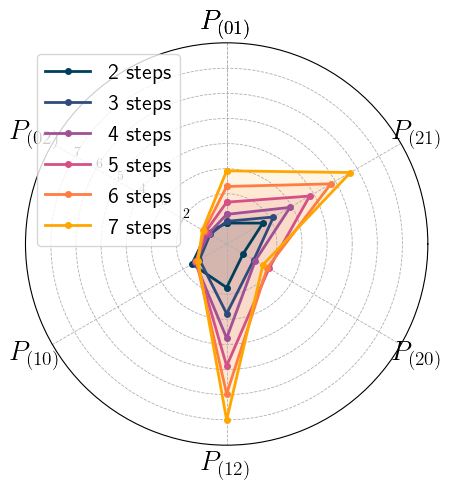

In [515]:
f = plt.figure(figsize = (5,5))
ax = plt.subplot(1,1,1,polar=True)

for s in range(len(steps_list)):
    stats = measure[s,:]
    angles = np.mod(np.pi/2 + np.linspace(0, 2*np.pi, len(laplacians_types), endpoint=False),2*np.pi)
    
    stats = np.concatenate((stats,[stats[0]]))

    angles =np.concatenate((angles,[angles[0]]))
    ax.plot(angles, stats, 'o-', linewidth=2,color = colors_sequential[int(np.floor(3/2*s))],markersize = 4,label = f"{steps_list[s]} steps")
    ax.fill(angles, stats, alpha=0.1,color = colors_sequential[int(np.floor(3/2*s))],label = "")

    ax.set_xticks(angles,[r"$P_{(%s)}$"%l for l in laplacians_types+[laplacians_types[0]]],fontsize = 20)
    ax.set_rticks([2,3,4,5,6,7],fontsize = 14)
    ax.set_rlabel_position(150.5)  # Move radial labels away from plotted line

    ax.set_ylim(0,max(np.max(measure)+1,4))
    #ax.grid(False)
    ax.grid(linewidth=0.6,linestyle = '--')


plt.legend(fontsize = 16)
plt.tight_layout()
#plt.savefig(f'../Experiments_results/Diffusion_Laplacians/Measures/Pseudofractal/fifa_PF.pdf')


## Compute measures normalized

In [5]:
def load_dataset(name,dim = 2):
    f = open(f"../Datasets/out.{name}","r")
    i = 0
    edges = []
    for line in f:
        if i != 0:
            words = line.split()
            edges.append((words[0],words[1]))
        else:
            i += 1
    f.close()
    G = nx.from_edgelist(edges)
    G = nx.convert_node_labels_to_integers(G)
    G.remove_edges_from(nx.selfloop_edges(G))
    Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
    G = G.subgraph(Gcc[0])
    sc = scomplex.convert_graph_to_sc(G,dim = dim)
    return sc

Compute the specific heats for all datasets, and for their randomizations with the configuration model

In [7]:
datasets = ["asoiaf", "ego-facebook", "subelj_euroroad_euroroad", "dimacs10-netscience", "arenas-email","dimacs10-celegans_metabolic"]#, "celegans", "ecoli", "mmusculus", "drosophila"]
#datasets = ["dimacs10-celegans_metabolic"]
laplacians_types = ["01","02","10","12","20","21"]

nrep = 10

# Compute eigenvalues of the Laplacians and their specific heat curves
taumin = -4 # Heat curve starts from 10**taumin
taumax = 5 # Heat curve ends at 10**taumax
ntau = 200 # Number of taus to consider in the interval

for name in datasets:
    print(name)
    sc = load_dataset(name)
    sp_heats = []
    sp_heats_cm = []
    for n in range(nrep):
        print(n)
        for l in range(len(laplacians_types)):    
            lap_type = laplacians_types[l]

            if n == 0:
                L = scomplex.diffusion_laplacian(sc, k=int(lap_type[0]), l=int(lap_type[1]),sparse = False)
                D,__ = np.linalg.eigh(L)
                D = np.abs(D)
                specific_heat,tau_space, __ = renormalize.compute_heat(D,taumin,taumax,ntau)
                sp_heats.append(specific_heat)

            # Configuration model
            A = scomplex.adjacency_of_order(sc, k=int(lap_type[0]), l=int(lap_type[1]),sparse = False)
            Gcm = nx.Graph(A)
            Gcm = nx.configuration_model([val for (node, val) in Gcm.degree()])
            L = nx.laplacian_matrix(Gcm).todense()
            D,__ = np.linalg.eigh(L)
            D = np.abs(D)
            specific_heat,tau_space, __ = renormalize.compute_heat(D,taumin,taumax,ntau)
            if n == 0:
                sp_heats_cm.append([specific_heat])
            else:
                sp_heats_cm[l].append(specific_heat)

    with open(f'../Experiments_results/Diffusion_Laplacians/Heat_curves/RealData/sp_heats/{name}_sp_heats.pickle', 'wb') as handle:
        pickle.dump(sp_heats, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(f'../Experiments_results/Diffusion_Laplacians/Heat_curves/RealData/sp_heats_cm/{name}_sp_heats.pickle', 'wb') as handle:
        pickle.dump(sp_heats_cm, handle, protocol=pickle.HIGHEST_PROTOCOL)


asoiaf
0


/Users/marconurisso/Desktop/Lavoro/Simplicial_Renormalization/HodgeLaplacianRenorm/higher_order_LRG/HOLR/Experiments_setups/../Functions/renormalize.py:28: RuntimeWarning: overflow encountered in exp
  mu[i] = 1 / np.sum(np.exp(-tau * (D - D[i])))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
<class 'networkx.utils.decorators.argmap'> compilation 20:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.


1
2
3
4
5
6
7
8
9
ego-facebook
0
1
2
3
4
5
6
7
8
9
subelj_euroroad_euroroad
0
1
2
3
4
5
6
7
8
9
dimacs10-netscience
0
1
2
3
4
5
6
7
8
9
arenas-email
0
1
2
3
4
5
6
7
8
9
dimacs10-celegans_metabolic
0
1
2
3
4
5
6
7
8
9


In [167]:
# Load real data

# pickle: asoiaf, ego-facebook,subelj_euroroad_euroroad, dimacs10-netscience, arenas-email, celegans, ecoli, mmusculus, drosophila

name = "ego-facebook"
with open(f'../Experiments_results/Diffusion_Laplacians/Heat_curves/RealData/sp_heats_cm/{name}_sp_heats.pickle', 'rb') as handle:
    sp_heats_cm = pickle.load(handle)
with open(f'../Experiments_results/Diffusion_Laplacians/Heat_curves/RealData/sp_heats/{name}_sp_heats.pickle', 'rb') as handle:
    sp_heats = pickle.load(handle)  


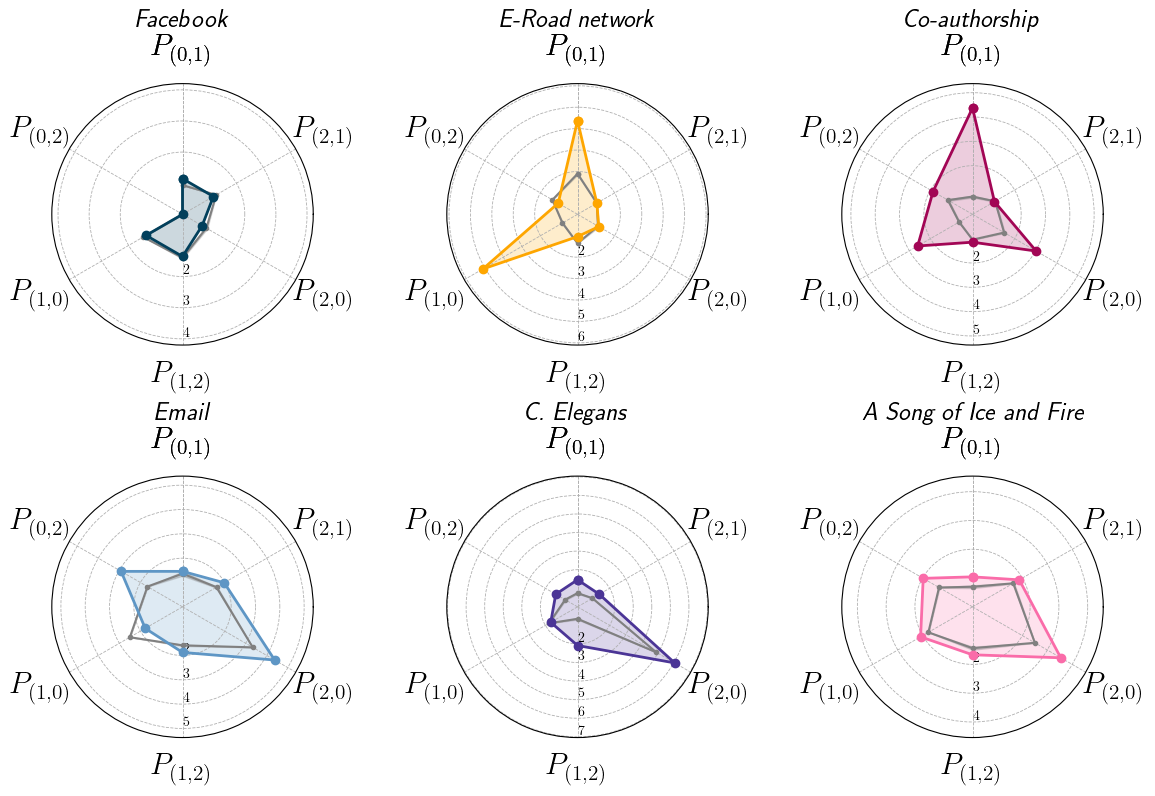

In [51]:
# Load real data

laplacians_types = ["01","02","10","12","20","21"]
nrep = 10
taumin = -4 # Heat curve starts from 10**taumin
taumax = 5 # Heat curve ends at 10**taumax
ntau = 200 # Number of taus to consider in the interval

tau_space = np.logspace(taumin,taumax,ntau)

names = ["ego-facebook","subelj_euroroad_euroroad", "dimacs10-netscience", "arenas-email","dimacs10-celegans_metabolic","asoiaf"]#, celegans, ecoli, mmusculus, drosophila
true_names = [r"\emph{Facebook}",r"\emph{E-Road network}",r"\emph{Co-authorship}",r"\emph{Email}",r"\emph{C. Elegans}", r"\emph{A Song of Ice and Fire}"]
fig = plt.figure(figsize = (4*3,4*2))
idx = 0
for nn,name in enumerate(names):

    with open(f'../Experiments_results/Diffusion_Laplacians/Heat_curves/RealData/sp_heats_cm/{name}_sp_heats.pickle', 'rb') as handle:
        sp_heats_cm = pickle.load(handle)

    with open(f'../Experiments_results/Diffusion_Laplacians/Heat_curves/RealData/sp_heats/{name}_sp_heats.pickle', 'rb') as handle:
        sp_heats = pickle.load(handle)  
    
    measure = np.zeros(len(laplacians_types))
    measure_cm = np.zeros((len(laplacians_types),nrep))

    for i in range(len(laplacians_types)):
        measure[i] = renormalize.measure_SI(tau_space,sp_heats[i],epsilon=0.15,ymin = -4,ymax = 2,ny = 100)
        for n in range(nrep):
            measure_cm[i,n] = renormalize.measure_SI(tau_space,sp_heats_cm[i][n],epsilon=0.15,ymin = -4,ymax = 2,ny = 100)

    #plt.figure(figsize=(5,5))
    ax = plt.subplot(2,3,idx+1, polar=True)
    #ax = axs[i]
    stats = measure
    stats_cm = np.mean(measure_cm,1)
    stats_cm_std = np.sqrt((nrep - 1)/nrep)*np.std(measure_cm,1)

    angles = np.mod(np.pi/2 + np.linspace(0, 2*np.pi, len(laplacians_types), endpoint=False),2*np.pi)
    stats = np.concatenate((stats,[stats[0]]))
    stats_cm = np.concatenate((stats_cm,[stats_cm[0]]))
    stats_cm_std = np.concatenate((stats_cm_std,[stats_cm_std[0]]))

    angles = np.concatenate((angles,[angles[0]]))
    ax.plot(angles,stats_cm,'o-',color = "gray", markersize = 3)
    ax.plot(angles, stats, 'o-', linewidth=2,color = colors_curves[idx])
    ax.fill(angles, stats, alpha=0.2,color = colors_curves[idx])
    ax.fill_between(angles, stats_cm + 1.96*stats_cm_std/np.sqrt(nrep),stats_cm - 1.96*stats_cm_std/np.sqrt(nrep), alpha=0.3, color = "gray")
    #ax.fill(angles, stats_cm - stats_cm_std, alpha=0.2, color = "gray")

    ax.set_xticks(angles,[f"$P_{{({l[0]},{l[1]})}}$" for l in laplacians_types+[laplacians_types[0]]],fontsize = 22)
    ax.set_rticks([ll for ll in range(2,int(max(np.max(measure)+2,5)))], fontsize =18)
    ax.set_rlabel_position(-90)  # Move radial labels away from plotted line
    ax.tick_params(axis='x', which='major', pad=13)

    ax.set_title(true_names[nn],fontsize = 18)
    #ax.set_title(r,fontsize=30)
    ax.set_ylim(0,max(np.max(measure)+1,4.2))
    ax.grid(True)
    ax.grid(linewidth=0.6,linestyle = '--')

    idx+=1

plt.tight_layout()
plt.savefig(f'../Experiments_results/Diffusion_Laplacians/Measures/RealData/fifa_correct.pdf')


## Compute measure XGI datasets

/var/folders/f6/5t2dxw1n72nf__cgdxs0x8m80000gn/T/ipykernel_12035/509489392.py:5: RuntimeWarning: divide by zero encountered in log
  sp_heat =  np.log(sp_heat)
/var/folders/f6/5t2dxw1n72nf__cgdxs0x8m80000gn/T/ipykernel_12035/509489392.py:5: RuntimeWarning: invalid value encountered in log
  sp_heat =  np.log(sp_heat)


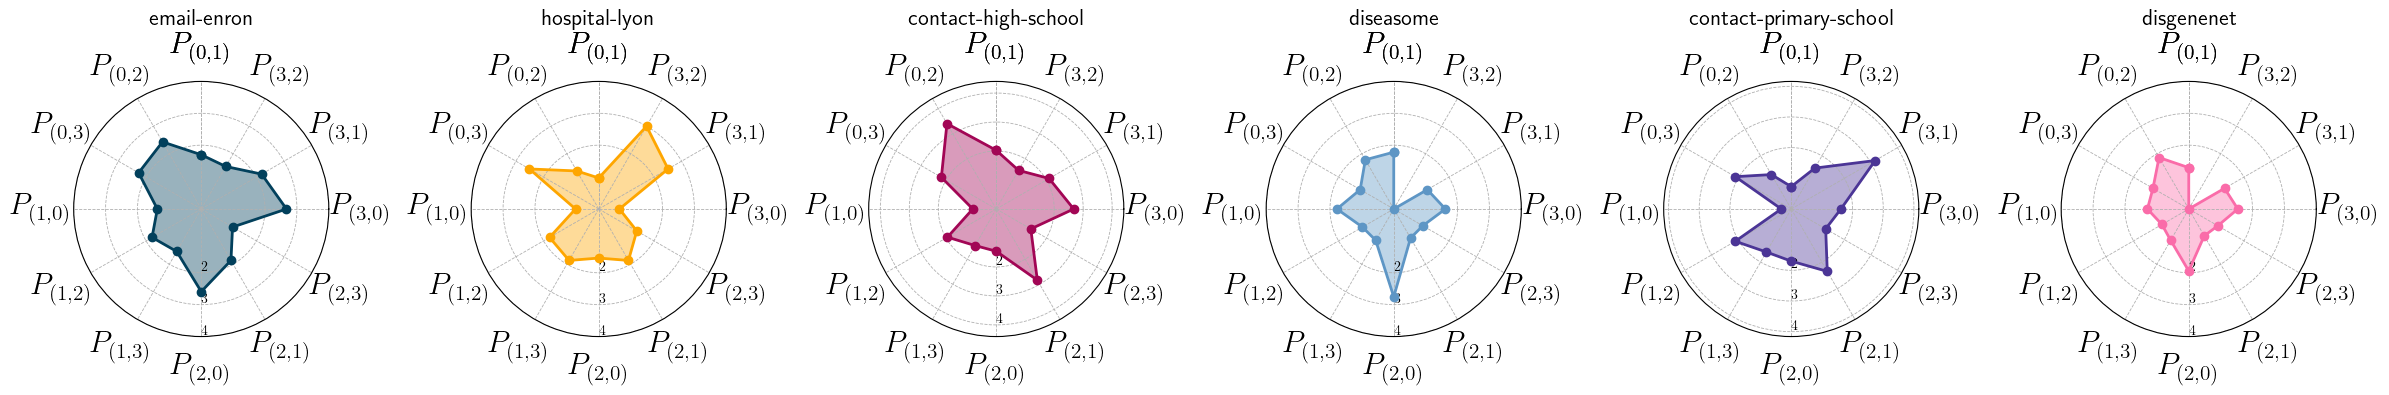

In [32]:
# email-enrom, hospital-lyon, contact-high-school, diseasome, contact-primary-school

# Load real data

names = ["email-enron", "hospital-lyon", "contact-high-school", "diseasome", "contact-primary-school","disgenenet"]
fig = plt.figure(figsize = (4*len(names),4))
idx = 0
for name in names:
    
    #with open(f'../Experiments_results/Diffusion_Laplacians/Heat_curves/RealData/sp_heats_cm/{name}_sp_heats.pickle', 'rb') as handle:
    #   sp_heats_cm = pickle.load(handle)
    with open(f'../Experiments_results/Diffusion_Laplacians/Heat_curves/RealData/sp_heats/{name}_sp_heats.pickle', 'rb') as handle:
        sp_heats = pickle.load(handle)  
    measure = np.zeros(len(laplacians_types))
    #measure_cm = np.zeros((len(laplacians_types),nrep))

    for i in range(len(laplacians_types)):
        measure[i] = measure_SI(tau_space,sp_heats[i],l=0.2,ymin = -4,ymax = 2,ny = 100)
        #for n in range(nrep):
        #    measure_cm[i,n] = measure_SI(tau_space,sp_heats_cm[i][n],l=0.2,ymin = -4,ymax = 2,ny = 100)

    #plt.figure(figsize=(5,5))
    ax = plt.subplot(1,len(names),idx+1, polar=True)
    #ax = axs[i]
    stats = measure
    #stats_cm = np.mean(measure_cm,1)
    #stats_cm_std = np.std(measure_cm,1)

    angles = np.mod(np.pi/2 + np.linspace(0, 2*np.pi, len(laplacians_types), endpoint=False),2*np.pi)
    stats = np.concatenate((stats,[stats[0]]))
    #stats_cm = np.concatenate((stats_cm,[stats_cm[0]]))
    #stats_cm_std = np.concatenate((stats_cm_std,[stats_cm_std[0]]))

    angles = np.concatenate((angles,[angles[0]]))
    ax.plot(angles, stats, 'o-', linewidth=2,color = colors_curves[idx])
    ax.fill(angles, stats, alpha=0.4,color = colors_curves[idx])
    #ax.fill_between(angles, stats_cm + stats_cm_std,stats_cm - stats_cm_std, alpha=0.2, color = "gray")
    #ax.fill(angles, stats_cm - stats_cm_std, alpha=0.2, color = "gray")

    ax.set_xticks(angles,[f"$P_{{({l[0]},{l[1]})}}$" for l in laplacians_types+[laplacians_types[0]]],fontsize = 22)
    ax.set_rticks([ll for ll in range(2,int(max(np.max(measure)+2,5)))], fontsize =18)
    ax.set_rlabel_position(-90)  # Move radial labels away from plotted line
    ax.tick_params(axis='x', which='major', pad=13)


    ax.set_title(name,fontsize = 16)
    #ax.set_title(r,fontsize=30)
    ax.set_ylim(0,max(np.max(measure)+1,4))
    ax.grid(True)
    ax.grid(linewidth=0.6,linestyle = '--')

    idx+=1

plt.tight_layout()
plt.savefig(f'../Experiments_results/Diffusion_Laplacians/Measures/RealData/xgi_datasets.pdf')


## Change beta

In [16]:
# Load NGF data (deserialize)

d = 3
s = 1
nrep = 30#10
N = 2000
nbeta = 10

#with open(f'../Experiments_results/Diffusion_Laplacians/Heat_curves/NGF/Data/d{d}s{s}_{nrep}rep_{N}nodes.pickle', 'rb') as handle:
with open(f'../Experiments_results/Diffusion_Laplacians/Heat_curves/NGF/Data/d{d}s{s}_{nrep}rep_{N}nodes_{nbeta}beta.pickle', 'rb') as handle:
    sp_heats = pickle.load(handle)



taumin = -3
taumax = 5
ntau = 200
tau_space = np.logspace(taumin,taumax,ntau)[:ntau-1]
beta_space = np.linspace(0,5,nbeta)

In [17]:
sp_heats_mean = []
for b,beta in enumerate(beta_space):
    sp_heats_mean.append(np.mean(np.array(sp_heats[b]),0))

In [18]:
from matplotlib import cm

In [19]:
viridis = cm.get_cmap('viridis', 12)
cols = viridis(np.linspace(0,1,nbeta))

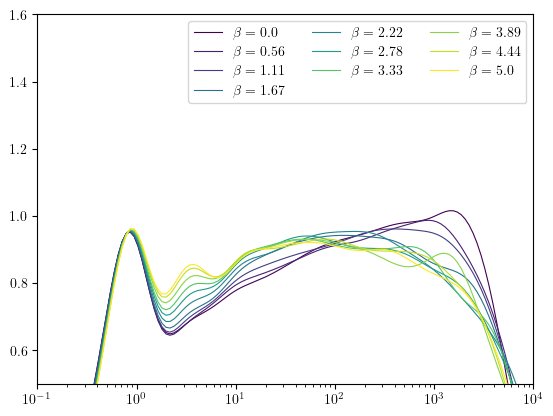

In [22]:
for b,beta in enumerate(beta_space):
    plt.semilogx(tau_space,sp_heats_mean[b],label = r"$\beta ="+f"{np.round(beta,2)}$",color = cols[b],linewidth=0.8)

plt.xlim([10**-1,10**4])
plt.ylim([5*10**-1,1.6*10**0])
plt.legend(ncol = len(beta_space)//3)
#plt.savefig(f'../Experiments_results/Diffusion_Laplacians/Heat_curves/NGF/change_beta_d3.pdf')
